Cat labels = 97, Dog labels = 101. <- Indicates mislabeling, supposed to be 99 of each!


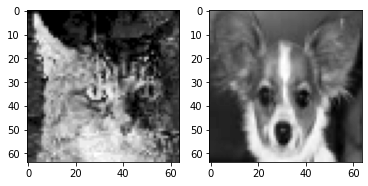

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

catsndogs = pd.read_csv('data\CATSnDOGS.csv')
labels = pd.read_csv('data\Labels.csv')


cat_ids = np.nonzero(labels.values[:,0]==0)[0] #[0] to get into tuple
dog_ids = np.nonzero(labels.values[:,0]==1)[0]

print(f'Cat labels = {len(cat_ids)}, Dog labels = {len(dog_ids)}. <- Indicates mislabeling, supposed to be 99 of each!')

catid = np.random.choice(cat_ids)
dogid = np.random.choice(dog_ids)

cat = catsndogs.iloc[catid].to_numpy().reshape((64,64), order='F')
dog = catsndogs.iloc[dogid].to_numpy().reshape((64,64), order='F')

fig, axs = plt.subplots(1, 2)
axs[0].imshow(cat, cmap='gray')
axs[1].imshow(dog, cmap='gray')
plt.show()


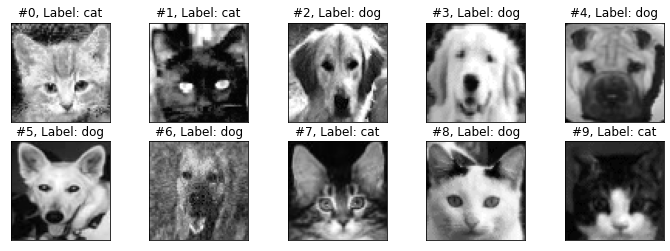

In [2]:
names = ['cat', 'dog']

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(12, 4))

for i, axr in enumerate(axs):
    for j, ax in enumerate(axr):
        ax.imshow(catsndogs.iloc[i*len(axr)+j].to_numpy().reshape((64,64), order='F'), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(f'#{i*len(axr)+j}, Label: {names[labels.values[i*len(axr)+j,0]]}')

# Question 1 (60p)



## 1a (10p)
 - Are the cats and dogs well separated, i.e. can you obtain good classification test accuracy performance on this data set? Compare at least 3 classifiers.

 - Are there any images that are consistently mislabeled by the classifiers (use resampling to ascertain)? Why do you think these are difficult images to classify? Do the classifiers struggle with the same observations?

 - Are the errors balanced or is one class more difficult to classify correctly?

In [3]:
# First we try to classify, using 3 classifiers
# Maybe Linear regression, QDA(?), and kNN?

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


x = catsndogs.to_numpy()
y = labels.values[:,0]
accuracy = {
    'knn': 0,
    'lr': 0,
    'rf': 0
}

mislabeled = {
    'knn': [],
    'lr': [],
    'rf': []
}
repetitions = 20


for i in range(repetitions):
    x_train, x_test, y_train, y_test = train_test_split(catsndogs, labels, test_size=0.2)

    # kNN
    knn = KNeighborsClassifier(n_neighbors=7)
    knn.fit(x_train, y_train.values[:,0])
    y_pred = knn.predict(x_test)
    accuracy['knn'] += np.sum(y_pred==y_test.values[:,0])/len(y_test) /repetitions
    mislabeled['knn'].extend(y_test.index[(y_pred!=y_test.values[:,0])].to_list())

    # Linear regression
    lr = LogisticRegression(max_iter=500)
    lr.fit(x_train, y_train.values[:,0])
    y_pred = lr.predict(x_test)
    accuracy['lr'] += np.sum(y_pred==y_test.values[:,0])/len(y_test) /repetitions
    mislabeled['lr'].extend(y_test.index[(y_pred!=y_test.values[:,0])].to_list())

    # Random forest
    rf = RandomForestClassifier()
    rf.fit(x_train, y_train.values[:,0])
    y_pred = rf.predict(x_test)
    accuracy['rf'] += np.sum(y_pred==y_test.values[:,0])/len(y_test) /repetitions
    mislabeled['rf'].extend(y_test.index[(y_pred!=y_test.values[:,0])].to_list())

#print(accuracy)
#print(mislabeled)


Fraction of dogs in the set of images mislabeled more than 2 times by one or more model:
0.7333333333333333


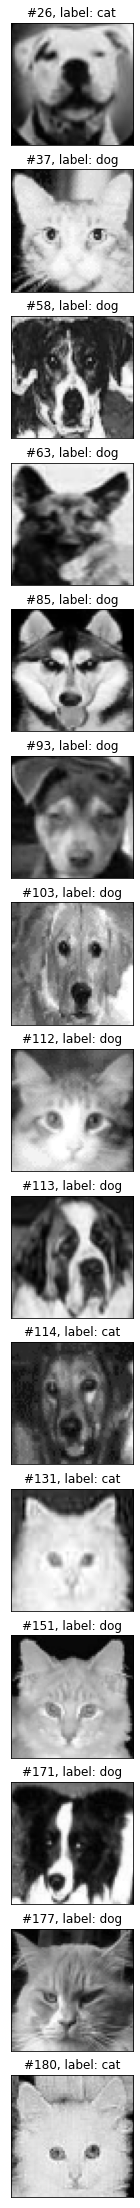

In [4]:
occurences = {}
threshold = 2   # More than this to occur "often"
combined = np.array([])

for key in mislabeled.keys():
    occurences[key] = np.bincount(mislabeled[key])
    tmp = np.array(mislabeled[key])
    combined = np.append(combined, np.unique(tmp[occurences[key][tmp]>threshold])).astype(int)

#print(np.bincount(combined))
#print(combined)

consistent_mislabels = np.argwhere(np.bincount(combined)>2).flatten()

# Visualize mislabeled images
fig, axs = plt.subplots(nrows=len(consistent_mislabels), ncols=1, figsize=(8,40))
for i, label in enumerate(consistent_mislabels):
    axs[i].imshow(catsndogs.iloc[label].to_numpy().reshape((64,64), order='F'), cmap='gray')
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
    axs[i].set_title(f'#{label}, label: {names[labels.values[label,0]]}')

# Are the errors balanced?
print(f'Fraction of dogs in the set of images mislabeled more than {threshold} times by one or more model:\n{np.sum(labels.values[consistent_mislabels,0])/len(labels.values[consistent_mislabels,0])}')

In [5]:
len(consistent_mislabels)

15

For kNN with k=5 we get 0.75, logistic regression we get 0.74, and random forest gives 0.71. This is better than random, but not particularly good.

Some images are quite consistently mislabeled. If we consider being mislabeled by all three classifiers more than twice out of 20 repetitions consistent, there are about 18 consistently mislabeled images. (9/18 mislabeled images, some dogs that have cat-like ears) However, despite 80/20 train/test split no images seem to be close to being mislabeled near 80% of the time, the most is around 20-50%     --(???)--

The errors are imbalanced, out of the consistently mislabeled images about 80% were labeled as "dog", although some where mislabeled. 

## 1b (10p)
 - Identify the most important pixels for classification - are these easy to identify or is there uncertainty in the selection of important features? Compare at least 3 methods for selecting/identifying features. Note, does not need to be the same methods as in 1a. Can you think of a way to improve on the stability of selection/identification?

 - Can you explain why these pixels are selected/are deemed important?

 - Do the identified predictive features differ between the classification methods?

In [41]:
# Logisticregression CV
# Train model on full dataset - get coef to make correct model

x = catsndogs.to_numpy()
y = labels.values[:,0]

lrCV = LogisticRegressionCV(Cs=np.logspace(-4, 4, 30), multi_class='ovr', solver='liblinear', penalty='l1', intercept_scaling=1000, scoring='accuracy').fit(x, y)

#lrCV = LogisticRegressionCV(Cs=hp, cv=n_folds, scoring='f1', penalty='l1', multi_class='ovr', solver='liblinear', intercept_scaling=10000).fit(x, y)

print(lrCV.C_)


[1.3738238]


In [63]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

repetitions = 50

lr = LogisticRegression(C=lrCV.C_[0], multi_class='ovr', solver='liblinear', penalty='l1')
lr_coefs = np.empty(shape=(repetitions, len(x[0])))

rf = RandomForestClassifier()
rf_coefs = np.empty(shape=(repetitions, len(x[0])))

lda = LinearDiscriminantAnalysis()
lda_coefs = np.empty(shape=(repetitions, len(x[0])))

for i in range(repetitions):
    if i % 50 == 0:
        print(f'bootstrap {i}')
    # Choose n random points
    idxs = np.random.choice(len(y), size=len(y), replace=True)
    x_tmp = x[idxs]
    y_tmp = y[idxs]

    # Fit model to points
    lr.fit(x_tmp, y_tmp)
    rf.fit(x_tmp, y_tmp)
    lda.fit(x_tmp, y_tmp)

    # Get coefficients to see most important features
    lr_coefs[i,:] = lr.coef_[0]
    rf_coefs[i,:] = rf.feature_importances_
    lda_coefs[i,:] = lda.coef_[0]

lda_coefs_mean = np.mean(lda_coefs, axis=0)
lr_coefs_mean = np.mean(lr_coefs, axis=0)
rf_coefs_mean = np.mean(rf_coefs, axis=0)

bootstrap 0


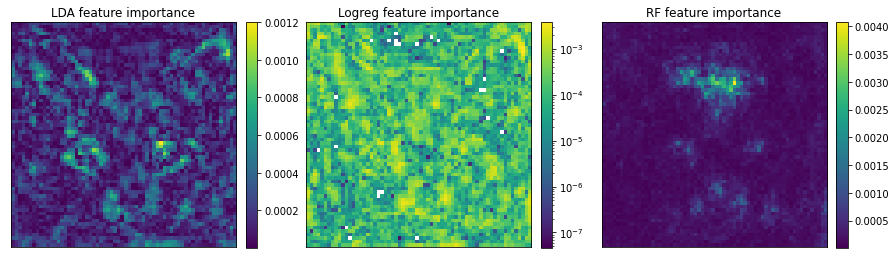

In [69]:
from matplotlib.colors import LogNorm

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

lda_importance = lda_coefs_mean.reshape((64,64), order='F')
im0 = axs[0].imshow(np.abs(lda_importance))
axs[0].set_title('LDA feature importance')
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

lr_importance = lr_coefs_mean.reshape((64,64), order='F')
im1 = axs[1].imshow(np.abs(lr_importance), norm=LogNorm())
axs[1].set_title("Logreg feature importance")

fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

rf_importance = rf_coefs_mean.reshape((64,64), order='F')
im2 = axs[2].imshow(rf_importance)
axs[2].set_title('RF feature importance')
fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

for ax in axs:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


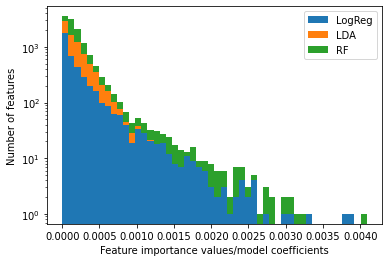

[3536 3127 2107 1165  703  459  285  208  141  101   67   43   52   42
   32   31   27   24   17   14   13   16    9    9    8    6    6    2
    7    7    3    5    1    3    2    0    2    2    1    1    1    0
    0    0    0    0    1    1    0    1]


<ErrorbarContainer object of 3 artists>

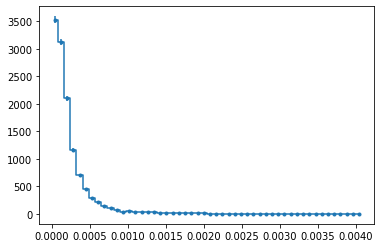

In [74]:
# Histograms
fig, ax = plt.subplots(nrows=1, ncols=1)

hist_data = np.stack([np.abs(lr_coefs_mean), np.abs(lda_coefs_mean), rf_coefs_mean], axis=-1)
ax.hist(hist_data, bins=50, histtype='bar', stacked=True, fill=True)
ax.set_yscale('log')
ax.set_ylabel('Number of features')
ax.set_xlabel('Feature importance values/model coefficients')
plt.legend(['LogReg', 'LDA', 'RF'])
plt.show()

fig2, ax = plt.subplots(nrows=1, ncols=1)

y, bin_edges = np.histogram(np.abs(lr_coefs_mean), bins=50)     # TODO göra en för varje?
bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])

print(y)

plt.errorbar(bin_centers, y, yerr= y**0.5, marker  ='.', drawstyle='steps-mid')

## 1c (10p)
Cluster the data set. Do the clusters agree with the class labels? Does changing the number of clusters have an impact on the overlap with the class labels?

What characteristics of the data does the clustering pick up?

Please think carefully about how you go about this question - how do you choose your input (e.g. do you perform preprocessing or not) to the clustering algorithm? what method and settings? Is it as clear cut how to make these choices if you didn't know the labels?

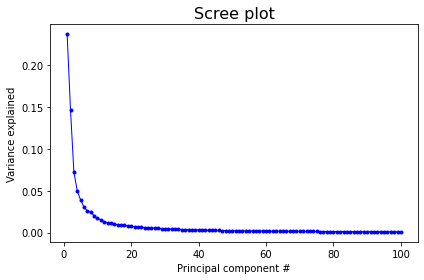

In [112]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
p_comps = pca.fit_transform(catsndogs)

principal_df = pd.DataFrame(p_comps)
combined_df = pd.concat([ labels['x'], principal_df], axis=1)

plt.plot(np.arange(pca.n_components_)+1, pca.explained_variance_ratio_, marker='o', markerfacecolor='blue', markersize=3, color='blue', linewidth=1)
plt.title('Scree plot',fontsize=16)
plt.xlabel('Principal component #')
plt.ylabel('Variance explained')
plt.tight_layout()
plt.show()


     x            0            1            2            3            4  \
0    0 -2731.106062  1403.814591   329.445998   767.707129  1302.724189   
1    0   637.649951 -1206.936306  -796.214295 -1410.718668   336.025905   
2    1 -1371.674206 -1438.013968  -289.873204   -85.099626  -634.403798   
3    1 -3458.994358  -771.788478  1399.494883  1299.372230  -956.657650   
4    1   952.879710 -1635.884918   211.876922  -870.592286  -504.636243   
..  ..          ...          ...          ...          ...          ...   
193  0 -1534.304974 -1231.017980 -1753.035020   221.652396  1382.992514   
194  1   571.834881  -863.798556  -972.476324  -494.472433   964.198976   
195  1  2067.930014  -494.753661  2394.640099 -1029.886232   216.210865   
196  0    76.741473  1555.343506  -487.795214   564.812738    -3.030355   
197  0  1987.318373   825.031138  -248.817787  1644.325362 -1805.290819   

               5            6            7           8  ...          90  \
0    -691.424923   985.8

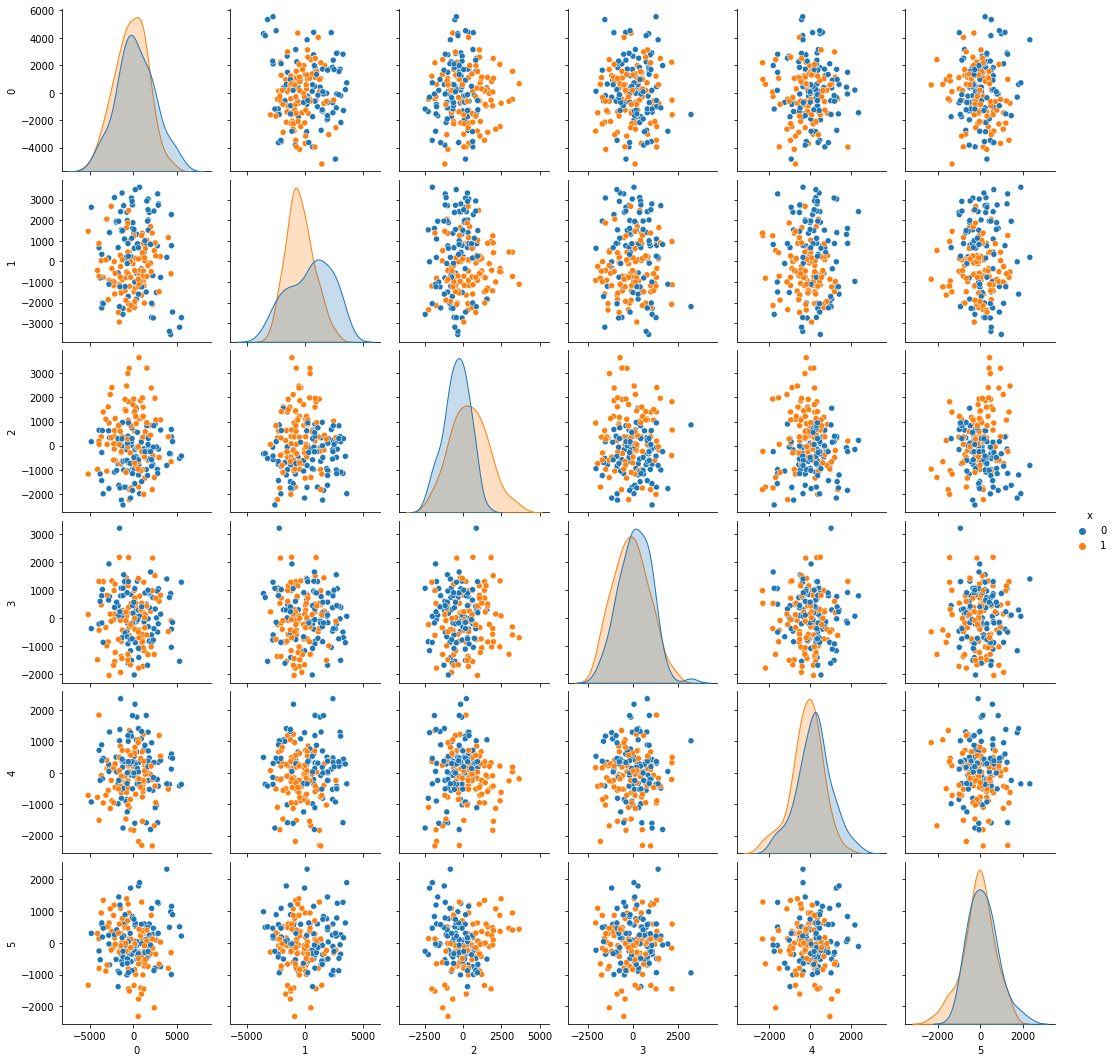

In [113]:
import seaborn as sns
print(combined_df.loc[:, :pca.n_components_-1])
sns.pairplot(combined_df.loc[:, :5], hue='x')

Text(33.0, 0.5, 'True label')

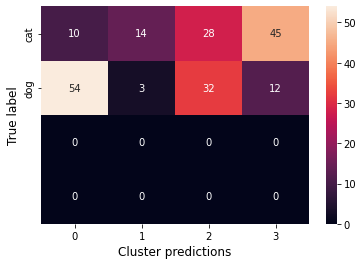

In [137]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

km = KMeans(n_clusters=4).fit(normalize(catsndogs))

conf_mat = confusion_matrix(labels.values, km.labels_)

s = sns.heatmap(conf_mat, annot=True, vmin=0, yticklabels=['cat', 'dog'])
s.set_xlabel('Cluster predictions', fontsize=12)
s.set_ylabel('True label', fontsize=12)


Idéer för att se hur väl kluster överensstämmer:
 - För bara n=2 funkar confusion matrix eller nån manuell beräkning som jag har för mig att jag gjort tidigare
 - Göra bar plots som i project 2? dvs Anta att majoriteten i det predictade klustret är "korrekt" och resten blir overlap(?) Blir ju typ vad de frågar efter, men känns inte så proffsigt/korrekt liksom. Går typ att kika på med skeva (2x3/4) confusion matrix som ovan men inte heller dunder

## 1d (10p)
Cluster the cat and dog data sets separately. How many clusters are there in the cat data? what about the dogs?

Are these the same or differ? Can you think of why? What characterstics of the data do the respective clusterings represent?

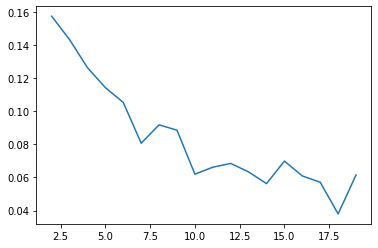

In [155]:
from sklearn.metrics import silhouette_score

cats = catsndogs[labels.values==0]
dogs = catsndogs[labels.values==1]

# Plan:
# Loopa över antal cluster, kör nån metric typ silhoutte för att 
# bestämma antal kluster. 

cat_silhouette = []
dog_silhouette = []

max_n = 20

for n in range(2,max_n):
    km = KMeans(n_clusters=n).fit(cats)
    cat_silhouette.append(silhouette_score(cats, km.labels_))
    

fig = plt.figure()
ax = fig.gca()

ax.plot(range(2, max_n), cat_silhouette)
# Blir rätt olika varje gång, kanske average med errorbars
